# MCMC Comparison

## surmise

1. Train a GP (using surmise) to emulate the ${}^3{\rm He}(\alpha,\gamma)$ observables. 
2. Use that GP to calculate the $R$-matrix parameter posteriors.
3. Compare to the results in our BRICK paper.


* CS model
* maximally 1000 training points

In [1]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import seaborn as sns
import emcee
import dill as pickle

import model

In [2]:
plt.style.use('science')
gr = (1 + np.sqrt(5)) / 2
h = 3

plt.rcParams['figure.dpi'] = 150

In [3]:
b = emcee.backends.HDFBackend('emulators/backends/emu_good_eps_1.0000e-02_ntrain_700_fat_0.3_cutoff_0.10.h5')

with open('emulators/emu_good_eps_1.0000e-02_ntrain_700_fat_0.3_cutoff_0.10.pkl', 'rb') as f:
    emu = pickle.load(f)

In [4]:
emu._info['pct'].shape

(573, 92)

In [5]:
np.cumsum(model.num_pts_scatter)

array([ 17,  46,  91, 137, 189, 241, 293, 345, 398, 451])

18.622441509832196
17
46
91
137
189
241
293
345
398
451


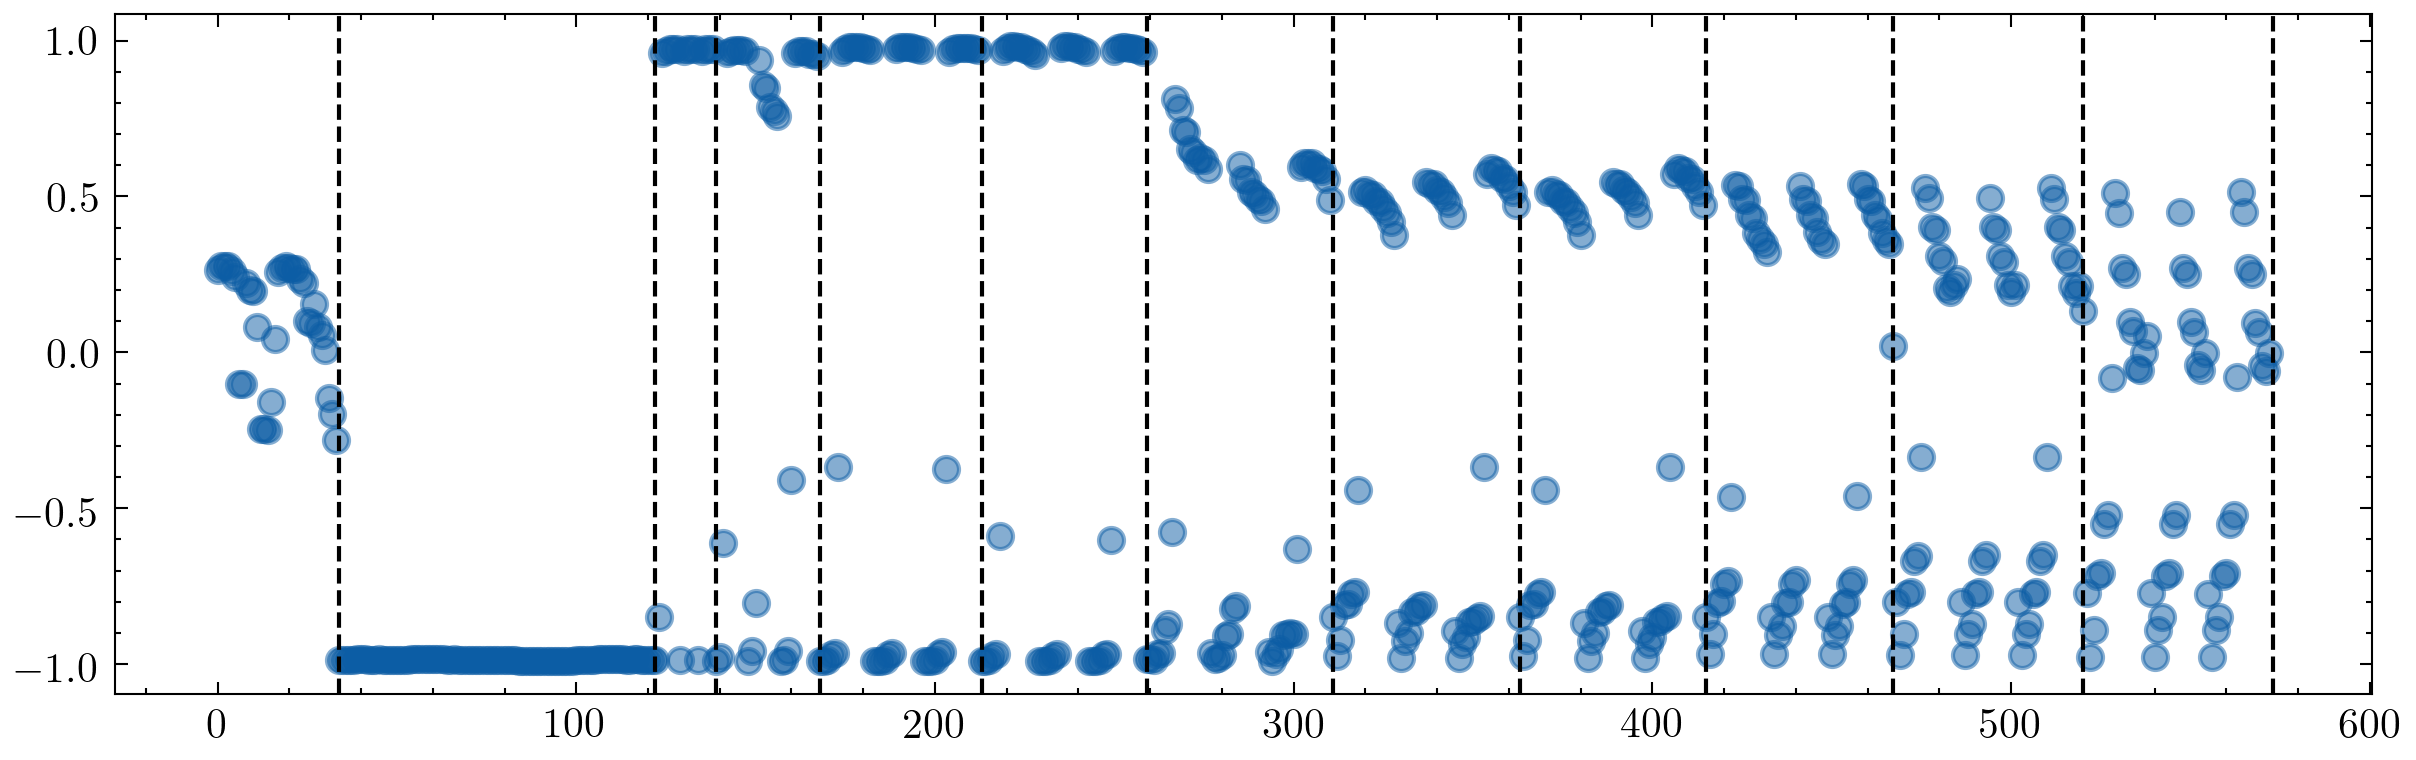

In [6]:
fig, ax = plt.subplots(figsize=(2*gr*h, h), dpi=300)
fig.patch.set_facecolor('white')

for i in range(1):
    row = emu._info['pct'][:, i]
    print(np.linalg.norm(row))
    ax.scatter(np.arange(row.size), row, alpha=0.5)

ax.axvline(model.nbr, color='k', linestyle='--')
ax.axvline(model.nbr+model.nxs, color='k', linestyle='--')
for i in np.cumsum(model.num_pts_scatter):
    print(i)
    ax.axvline(model.nbr+model.nxs+i, color='k', linestyle='--')

In [7]:
sum(model.num_pts_scatter)

451

In [8]:
chain = b.get_chain()

58 64


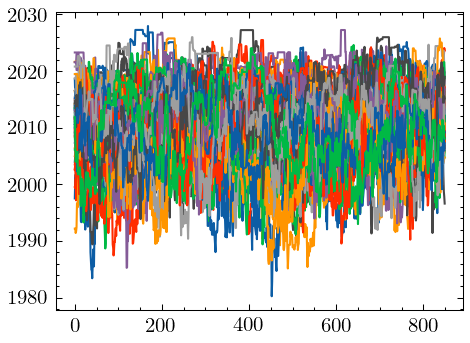

In [9]:
nb = 150
cutoff = 1980

lnp = b.get_log_prob()

ii = np.where(np.min(lnp[nb:, :], axis=0) > cutoff)[0]
print(ii.size, lnp.shape[1])

plt.plot(lnp[nb:, ii]);

In [10]:
design_chain = np.load('datfiles/fat_0.3_posterior_chain.npy')

def plot_chain_summary(ch, ax):
    low, med, high = np.quantile(ch, [0.16, 0.5, 0.84])
    ax.axhspan(low, high, color='C1', alpha=0.5)
    ax.axhline(med, color='C1')

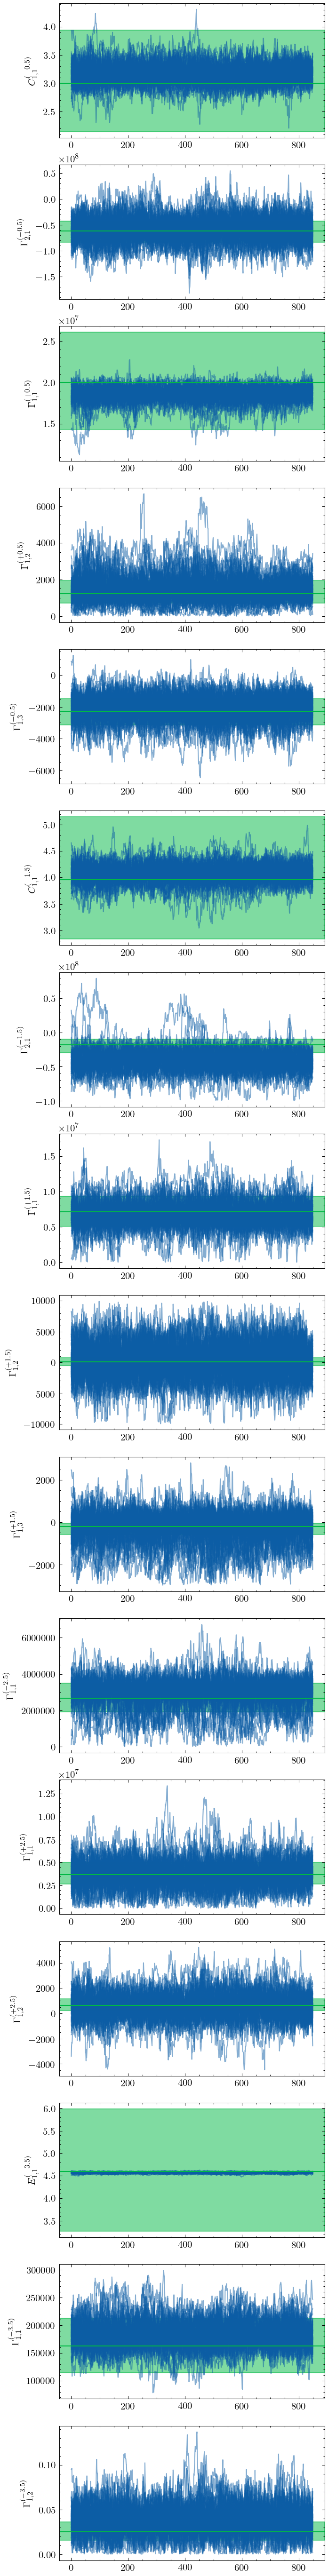

In [11]:
fig, ax = plt.subplots(model.nrpar, figsize=(gr*h, model.nrpar*h))
fig.patch.set_facecolor('white')

for i in range(model.nrpar):
    ax[i].plot(chain[nb:, ii, i], alpha=0.5, color='C0')
    ax[i].set_ylabel(model.azr.config.labels[i])
    plot_chain_summary(design_chain[:, i], ax[i])

In [12]:
# fig, ax = plt.subplots(model.nf_capture, 
#                        figsize=(gr*h, model.nf_capture*h))
# fig.patch.set_facecolor('white')

# for (j, i) in enumerate(range(model.nrpar, model.nrpar + model.nf_capture)):
#     ax[j].plot(chain[:, :, i], alpha=0.5, color='C0')

In [13]:
# fig, ax = plt.subplots(model.nf_scatter, 
#                        figsize=(gr*h, model.nf_scatter*h))
# fig.patch.set_facecolor('white')

# for (j, i) in enumerate(range(model.nrpar + model.nf_capture, model.ndim)):
#     ax[j].plot(chain[:, :, i], alpha=0.5, color='C0')

In [14]:
n1 = model.nbr
n2 = model.nxs

In [15]:
flat_chain = b.get_chain(flat=True)
lnp = b.get_log_prob(flat=True)
theta_star = flat_chain[np.argmax(lnp), :]

In [16]:
lnp[np.argmin(lnp)]

-16526.085134602014

In [17]:
lnp.shape

(64000,)

In [18]:
theta_bad = flat_chain[np.argmin(lnp), :]

In [19]:
np.argmin(lnp)

14

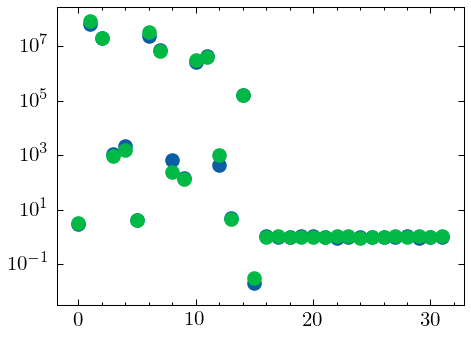

In [20]:
plt.scatter(np.arange(theta_bad.size), np.abs(theta_bad))
plt.scatter(np.arange(theta_star.size), np.abs(theta_star))
plt.yscale('log');

In [21]:
from bayes import ln_prior, Model

In [22]:
m = Model(emu)

In [23]:
m.ln_likelihood(theta_bad)

-19320.526886226307

In [24]:
m.ln_likelihood(theta_star)

1492.0438491482776

In [25]:
print(f'{m.ln_likelihood(theta_bad, include_gp_var=False):.4e}')
print(f'{m.ln_likelihood(theta_star, include_gp_var=False):.4e}')

-2.9004e+05
1.6130e+03


In [26]:
from multiprocessing import Pool

In [27]:
# with Pool(processes=16) as pool:
#     lnpi = pool.map(ln_prior, flat_chain)

In [28]:
# lnpi = np.array(lnpi)

In [29]:
# plt.hist(lnp[500:] - lnpi[500:],bins=200, density=True)
# # plt.xlim([-1000, 750])
# plt.xlabel('$\ln\mathcal{L}$')
# plt.ylabel('Density');

In [30]:
mu_star = model.calculate(theta_star)
mu_bad = model.calculate(theta_bad)

In [31]:
def plot_prediction(theta, ax, start, stop, color='C2', label=None, x=model.x):
    p = emu.predict(theta=theta[:16])
    mu = p.mean().flatten()
    var = p.var().flatten()
    ax.errorbar(x[start:stop], mu[start:stop], yerr=np.sqrt(var[start:stop]),
                linestyle='', capsize=2, color=color, marker='x', alpha=0.5, label=label)

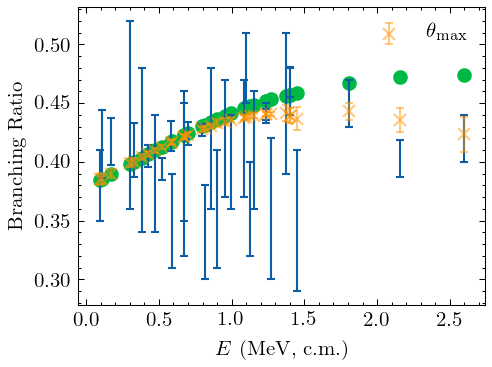

In [32]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[:n1], model.y[:n1], yerr=model.dy[:n1], linestyle='', capsize=2)
ax.scatter(model.x[:n1], mu_star[:n1], color='C1')
# ax.scatter(model.x[:n1], mu_bad[:n1], color='C4')

plot_prediction(theta_star, ax, 0, n1, label=r'$\theta_{\max}$')
# plot_prediction(theta_bad, ax, 0, n1, color='C3', label=r'$\theta_{\min}$')
# ax.errorbar(model.x[:n1], mu_star_gp[:n1], yerr=np.sqrt(mu_star_gp_var[:n1]), linestyle='', capsize=2, color='C2')

ax.legend()
ax.set_ylabel('Branching Ratio')
ax.set_xlabel('$E$ (MeV, c.m.)');

In [33]:
import bayes
m4 = bayes.Model4(emu)

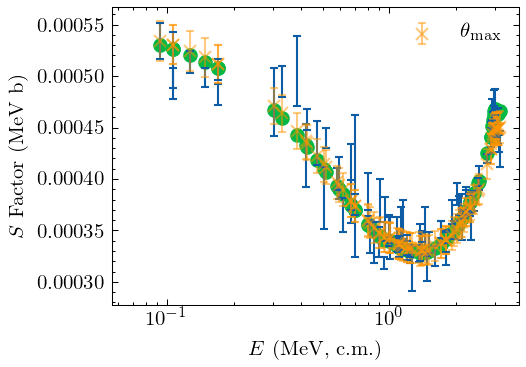

In [49]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.x[n1:n1+n2], model.y[n1:n1+n2], yerr=model.dy[n1:n1+n2], linestyle='',
            capsize=2)
# ax.errorbar(model.x[n1:n1+n2], m4.y[n1:n1+n2], yerr=m4.dy[n1:n1+n2], linestyle='',
#             capsize=2, color='C1')

plot_prediction(theta_star, ax, n1, n1+n2, label=r'$\theta_{\max}$', color='C2')
# plot_prediction(theta_bad, ax, n1, n1+n2, color='C3', label=r'$\theta_{\min}$')

ax.scatter(model.x[n1:n1+n2], mu_star[n1:n1+n2], color='C1')
# ax.scatter(model.x[n1:n1+n2], mu_bad[n1:n1+n2], color='C4')

# ax.scatter(model.x[n1:n1+n2], 1000*mu_star[n1:n1+n2], color='C1')
# ax.errorbar(model.x[n1:n1+n2], 1000*mu_star_gp[n1:n1+n2], yerr=1000*np.sqrt(mu_star_gp_var[n1:n1+n2]), linestyle='',
#             capsize=2, color='C2')

ax.legend()
ax.set_ylabel('$S$ Factor (MeV b)')
ax.set_xlabel('$E$ (MeV, c.m.)')
ax.set_xscale('log');

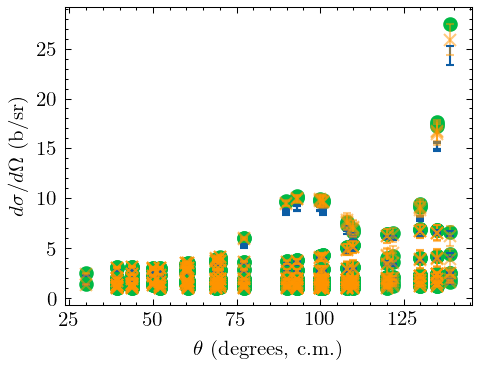

In [47]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

ax.errorbar(model.angles[n1+n2:], model.y[n1+n2:], yerr=model.dy[n1+n2:], linestyle='',
            capsize=2)

plot_prediction(theta_star, ax, n1+n2, None, label=r'$\theta_{\max}$', x=model.angles)
# plot_prediction(theta_bad, ax, n1+n2, None, color='C3', label=r'$\theta_{\min}$')

ax.scatter(model.angles[n1+n2:], mu_star[n1+n2:], color='C1')
# ax.errorbar(model.x[n1+n2:], mu_star_gp[n1+n2:], yerr=np.sqrt(mu_star_gp_var[n1+n2:]), linestyle='',
#             capsize=2, color='C2')

ax.set_ylabel(r'$d\sigma/d\Omega$ (b/sr)')
ax.set_xlabel(r'$\theta$ (degrees, c.m.)');
# ax.set_yscale('log');

In [48]:
import sonik_data as sd

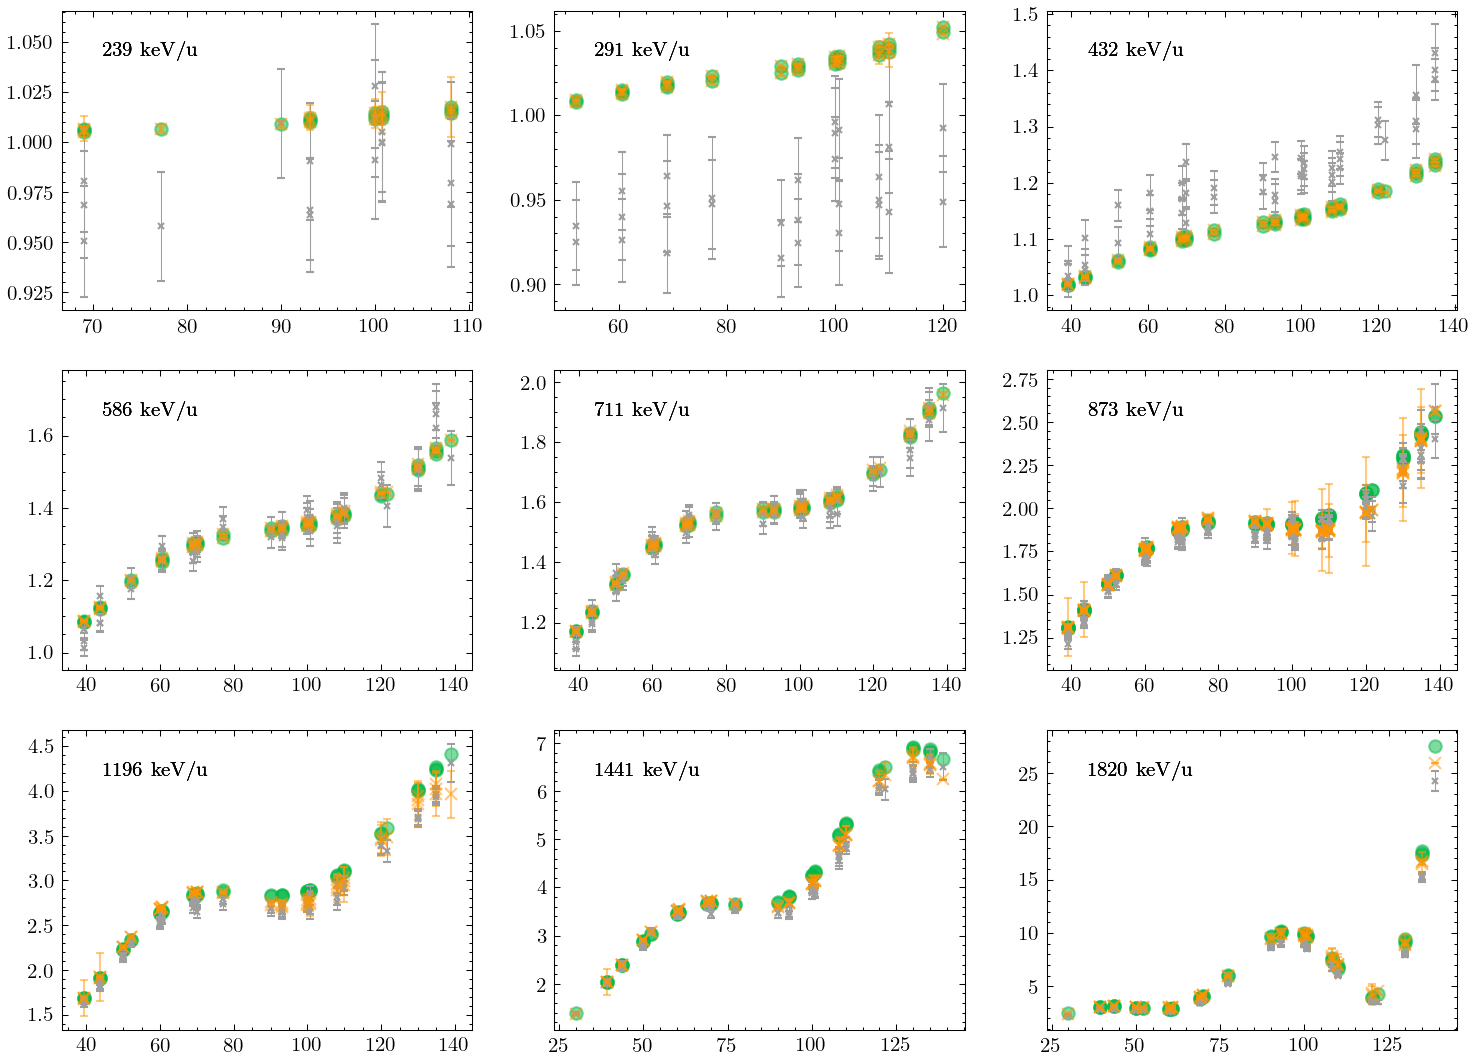

In [36]:
p = emu.predict(theta=theta_star[:16])
mu = p.mean().flatten()
var = p.var().flatten()

fig = sd.plot_sonik_data()
sd.plot_gp_prediction(mu[n1+n2:], np.sqrt(var), fig=fig)
sd.plot_azure2_prediction(mu_star[n1+n2:], fig=fig)

In [37]:
from run import Run

In [38]:
import pickle

with open('/spare/odell/7Be/CP/samples/model_1_2021-08-06-02-55-37.pkl', 'rb') as f:
    run = pickle.load(f)

In [39]:
cs_flat_chain = run.get_flat_chain()

In [40]:
for (l, x) in zip(model.azr.config.labels, theta_star):
    print(l, x)

$C_{1,1}^{(-0.5)}$ 3.1944249963040474
$\Gamma_{2,1}^{(-0.5)}$ -82347040.39529368
$\Gamma_{1,1}^{(+0.5)}$ 19819142.22309587
$\Gamma_{1,2}^{(+0.5)}$ 943.6450775123005
$\Gamma_{1,3}^{(+0.5)}$ -1556.5222774474646
$C_{1,1}^{(-1.5)}$ 4.12868937213432
$\Gamma_{2,1}^{(-1.5)}$ -34029293.312807545
$\Gamma_{1,1}^{(+1.5)}$ 6707026.401567551
$\Gamma_{1,2}^{(+1.5)}$ -238.9227279026221
$\Gamma_{1,3}^{(+1.5)}$ 133.6509255740166
$\Gamma_{1,1}^{(-2.5)}$ 2973499.358866748
$\Gamma_{1,1}^{(+2.5)}$ 4014585.383381134
$\Gamma_{1,2}^{(+2.5)}$ 1015.354121863597
$E_{1,1}^{(-3.5)}$ 4.577352399132985
$\Gamma_{1,1}^{(-3.5)}$ 165384.06873868062
$\Gamma_{1,2}^{(-3.5)}$ 0.03062396317866217


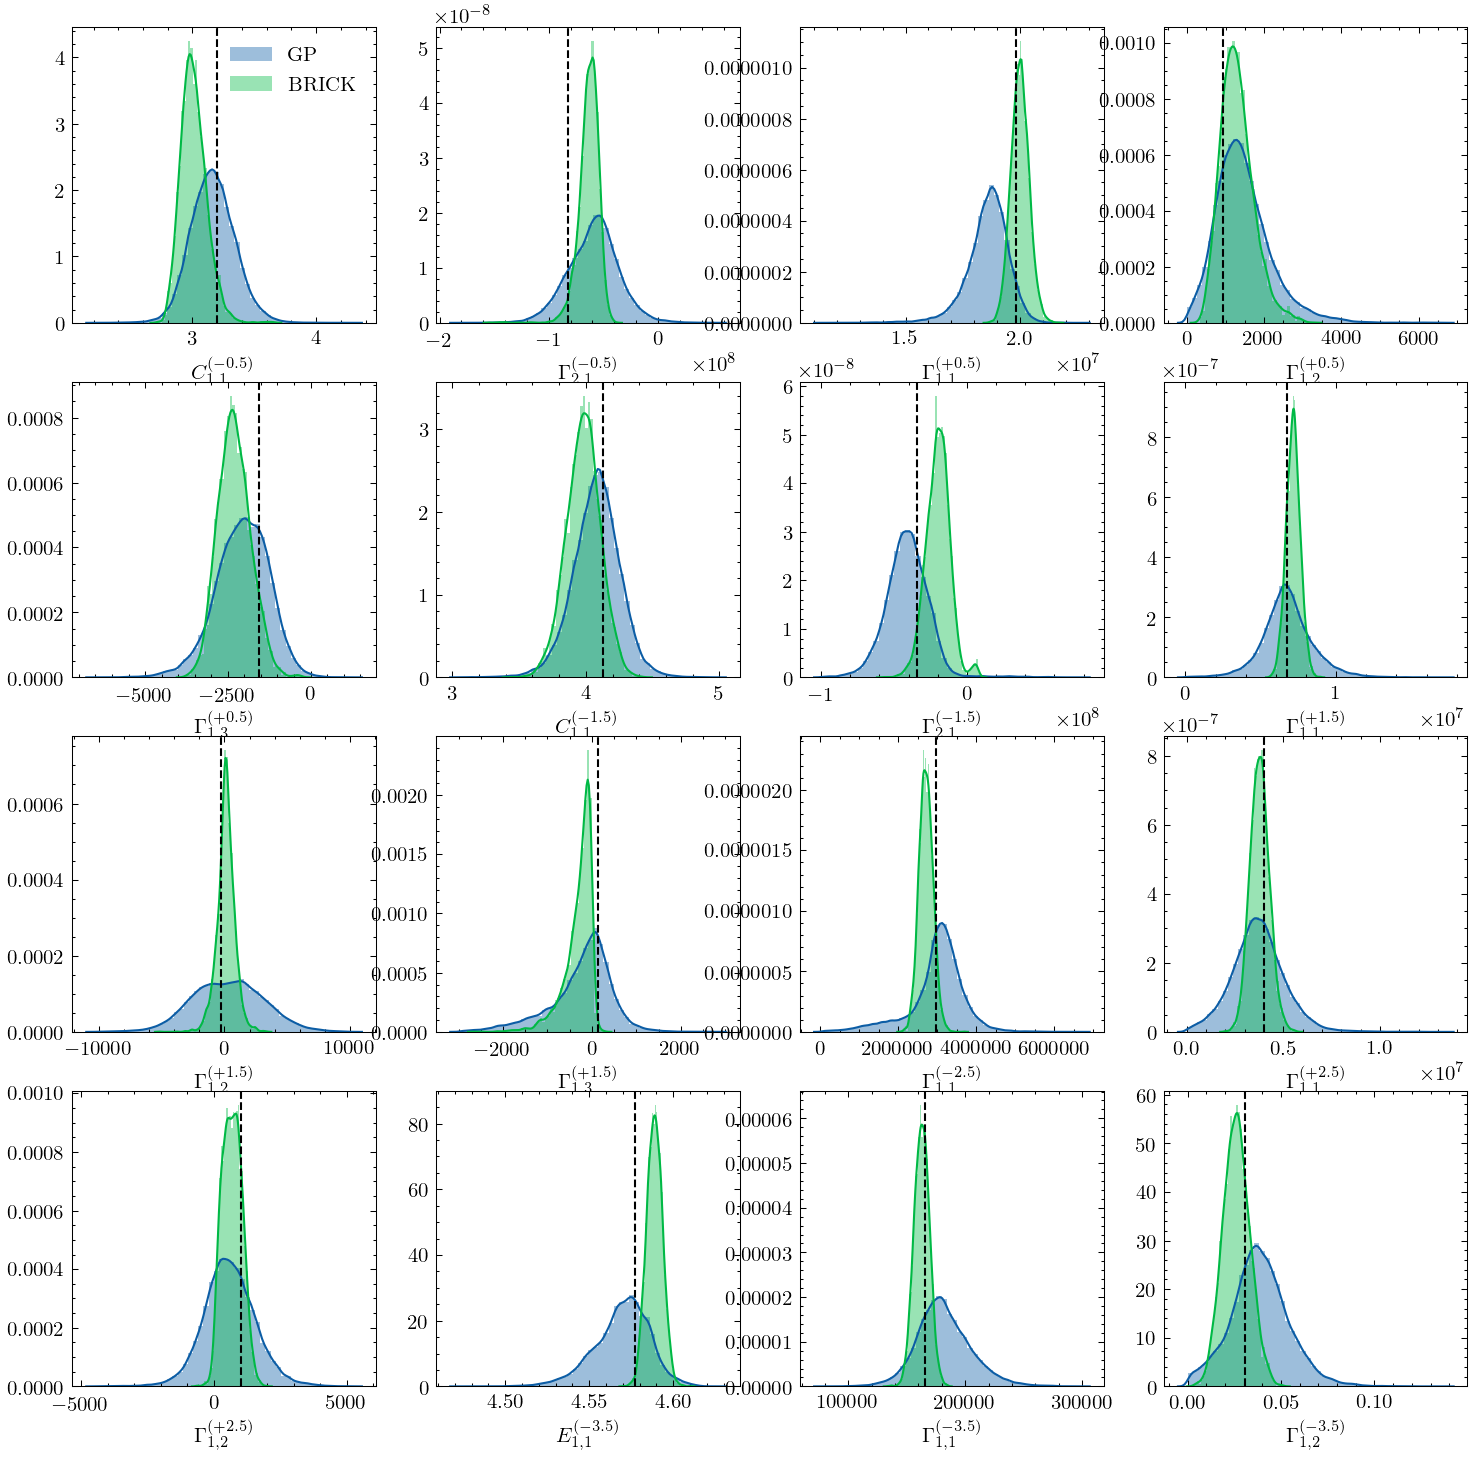

In [41]:
fig, ax = plt.subplots(4, ncols=4, figsize=(4*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(4):
    for j in range(4):
        k = i*4 + j
        sns.distplot(chain[nb:, ii, k].flatten(), ax=ax[i, j], label='GP')
        sns.distplot(cs_flat_chain[:, k], ax=ax[i, j], label='BRICK')
        ax[i, j].set_xlabel(model.azr.config.labels[k])
        ax[i, j].axvline(theta_star[k], color='k', linestyle='--')
ax[0, 0].legend();

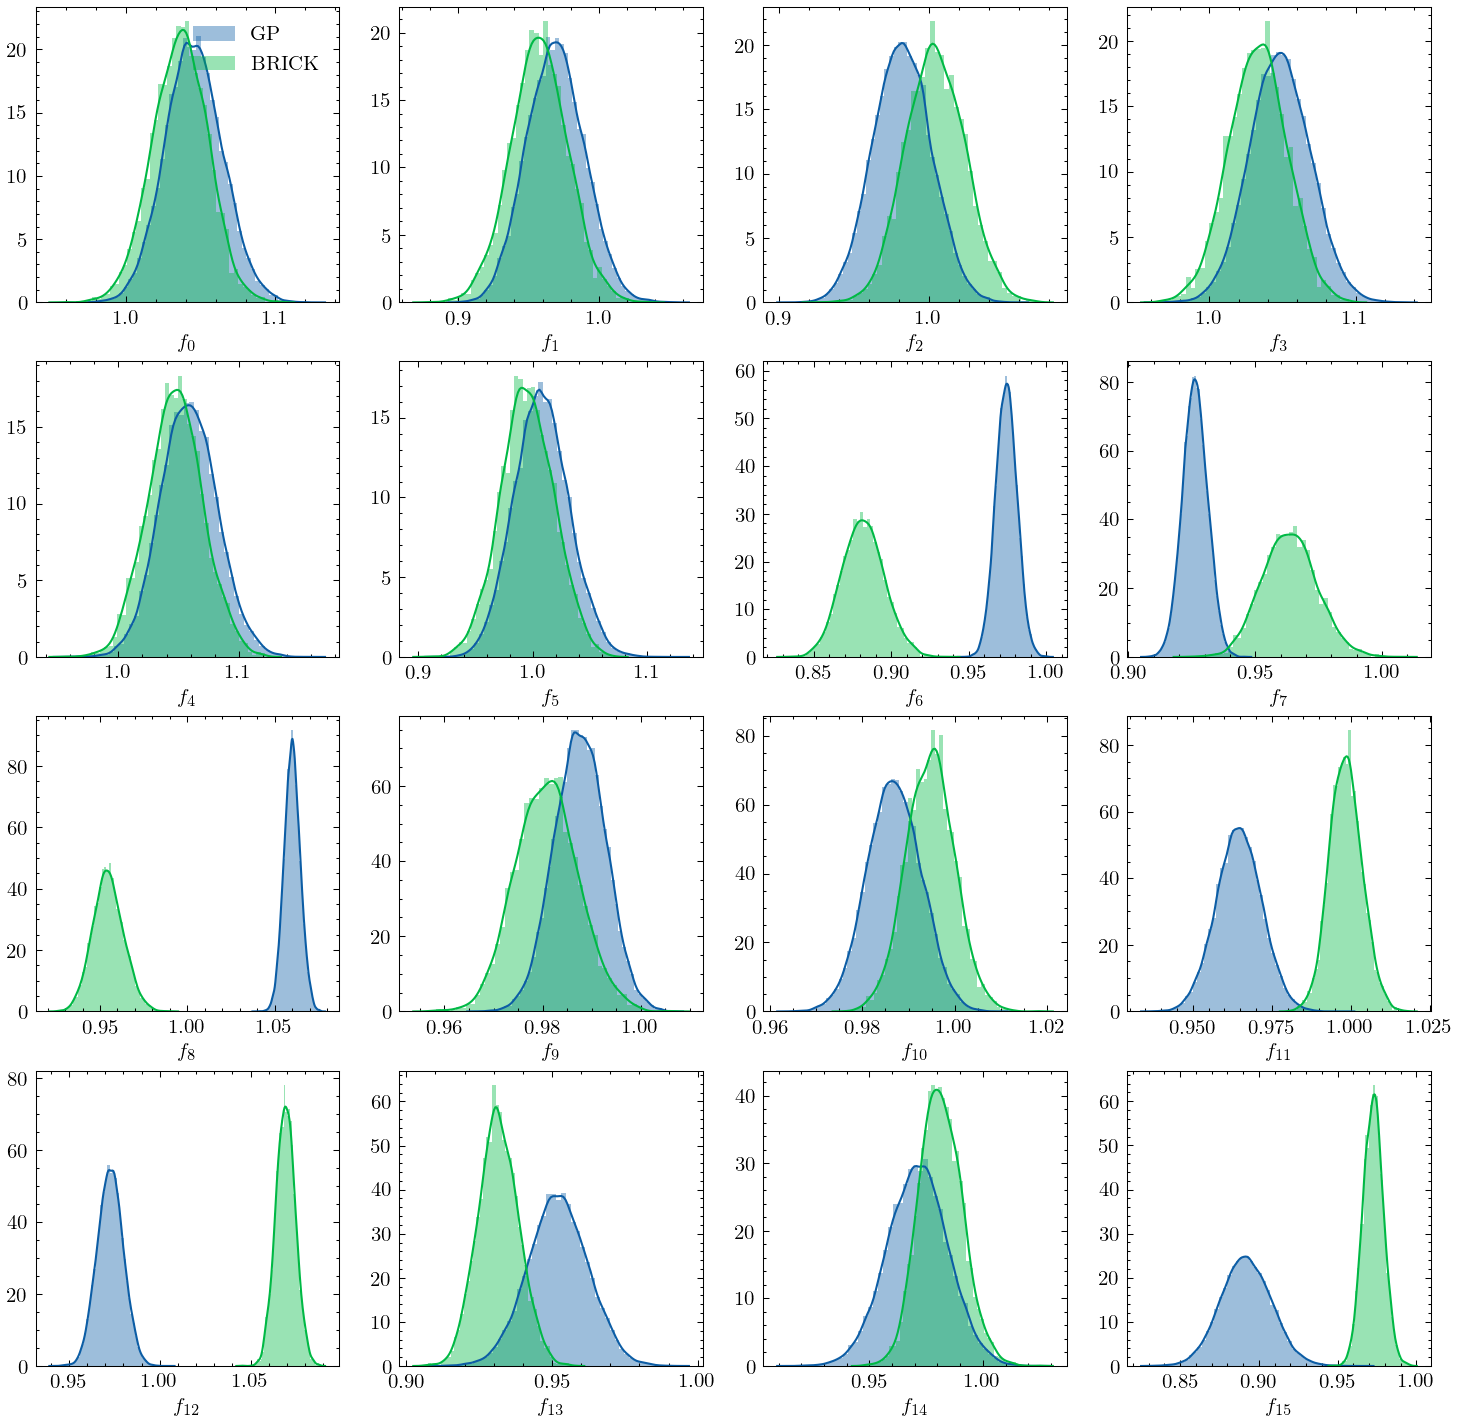

In [42]:
fig, ax = plt.subplots(4, ncols=4, figsize=(4*h, 4*h))
fig.patch.set_facecolor('white')

for i in range(4):
    for j in range(4):
        k = 16 + i*4 + j
        sns.distplot(1/chain[nb:, ii, k].flatten(), ax=ax[i, j], label='GP')
        sns.distplot(cs_flat_chain[:, k], ax=ax[i, j], label='BRICK')
        ax[i, j].set_xlabel('$f_{%d}$' % (k-16))
ax[0, 0].legend();

In [44]:
%%time
model.calculate(theta_star);

CPU times: user 17.7 ms, sys: 48.6 ms, total: 66.3 ms
Wall time: 327 ms


array([4.04469724e-01, 4.10362948e-01, 4.15535880e-01, 4.18845613e-01,
       4.24481966e-01, 4.28164052e-01, 4.36084975e-01, 4.36070225e-01,
       3.95064696e-01, 3.91283175e-01, 3.90542175e-01, 4.35236921e-01,
       4.35845607e-01, 4.35845607e-01, 4.28811722e-01, 4.17568905e-01,
       3.98089996e-01, 4.03032731e-01, 4.07935906e-01, 4.13116072e-01,
       4.19421333e-01, 4.23146101e-01, 4.23160253e-01, 4.28789955e-01,
       4.30100433e-01, 4.31456893e-01, 4.32687121e-01, 4.33616753e-01,
       4.35019945e-01, 4.35513399e-01, 4.35719348e-01, 4.36099514e-01,
       4.36042937e-01, 4.35414131e-01, 4.47020000e-04, 4.19540000e-04,
       3.96440000e-04, 3.82370000e-04, 3.60090000e-04, 3.46630000e-04,
       3.20560000e-04, 3.20540000e-04, 4.21140000e-04, 3.99280000e-04,
       3.75610000e-04, 3.31130000e-04, 5.14170000e-04, 5.10600000e-04,
       5.04780000e-04, 4.98830000e-04, 4.92830000e-04, 4.92660000e-04,
       5.10620000e-04, 3.60320000e-04, 3.45980000e-04, 3.35220000e-04,
      

In [46]:
%%time
emu.predict(theta=theta_star[:16]);

CPU times: user 1.38 s, sys: 73.9 ms, total: 1.45 s
Wall time: 93.5 ms


A emulation prediction object predict where the code in located in the file  emulation.  The main method are predict.covx, predict.covxhalf, predict.covxhalf_gradtheta, predict.lpdf, predict.lpdf_gradtheta, predict.mean, predict.mean_gradtheta, predict.rnd, predict.var.  Default of predict() is predict.mean() and predict(s) will run pred.rnd(s). Run help(predict) for the document string.

In [42]:
model.x - emu._info['x']

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [44]:
emu._info['pc'].shape

(684, 94)

In [ ]:
from sklearn.metrics import explained_variance_score
from bayes import Model3

m = Model3(emu)

In [ ]:
mu_gp, sigma_gp = m.gp_predict(theta=theta_star[:16])

In [ ]:
f_data = m.normalization_factors(theta_star)

In [ ]:
explained_variance_score(mu_star, mu_gp)

In [ ]:
flat_chain.shape

In [ ]:
R2_values = []

for theta in flat_chain[::64, :]:
    R2 = explained_variance_score(
        model.calculate(theta), 
        m.gp_predict(theta[:16])[0]
    )
    print(R2)
    R2_values.append(R2)

In [ ]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

sns.distplot(R2_values, ax=ax)
ax.set_xlabel('$R^2$');